In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import location_station, find_set_sunrise, find_set_sunset
from utils import generate_and_avaliate_model

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,s4
2013-12-01 03:30:00,33.624428,-0.428246,-0.020502,-3.216613,0.002355,1.826065,1.991653,0.163334
2013-12-01 03:40:00,33.205025,-0.546589,-0.118343,-3.122300,0.130198,4.588494,2.530373,0.165397
2013-12-01 03:50:00,32.539631,-0.772594,-0.226005,-2.810556,0.280756,7.786990,2.862830,0.168683
2013-12-01 04:00:00,31.469337,-1.082859,-0.310265,-2.320938,0.399753,10.972091,2.894375,0.173552
2013-12-01 04:10:00,29.995466,-1.429647,-0.346788,-1.764129,0.443303,13.734955,2.621609,0.178917


# SVM para regressão
## Completa

In [4]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
O erro quadrático médio foi: 0.006187
O erro quadrático total foi: 2.799733
O maior erro por previsão foi: 0.483897
O erro relativo foi: 28.564460%
O número de verdadeiros negativos foi: 518
O número de verdadeiros positivos foi: 147
O número de falsos negativos foi: 6
O número de falsos positivos foi: 596
O POD foi: 0.960784
O FAR foi: 0.802153
A ACC foi: 0.524862
O kappa foi: 0.056513
precission: 0.197847
recal: 0.960784
f1: 0.328125


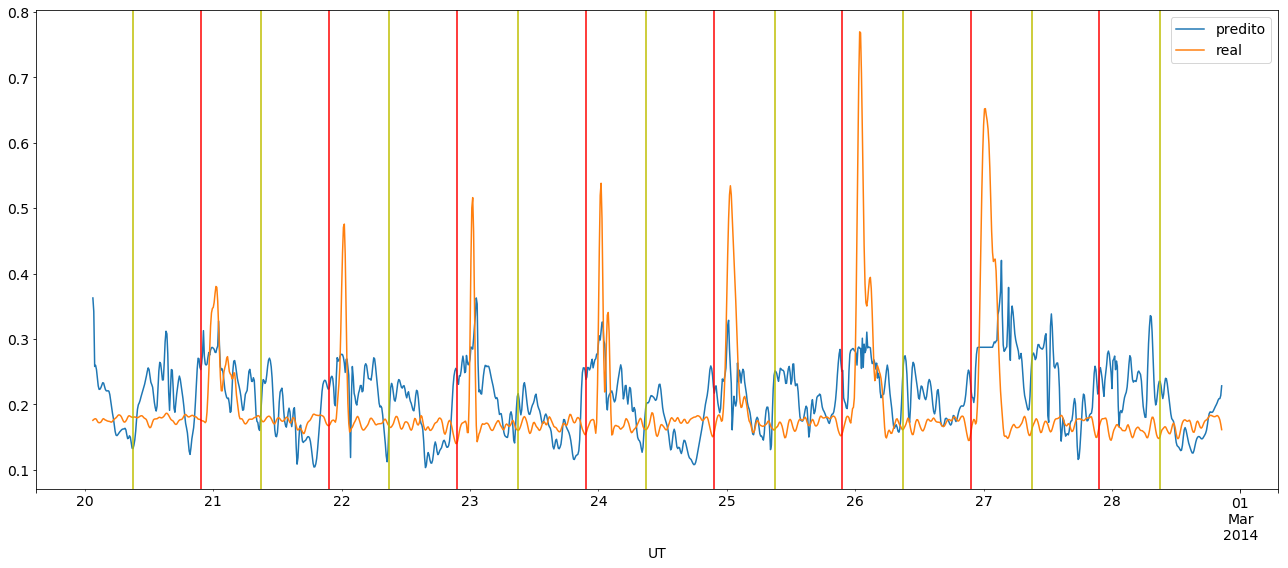

In [5]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4',
                                         file_to_save_model='./images/regression_svm.eps')

## Sem vtec

In [6]:
instances_set = ['vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
O erro quadrático médio foi: 0.006615
O erro quadrático total foi: 2.894953
O maior erro por previsão foi: 0.469727
O erro relativo foi: 32.209552%
O número de verdadeiros negativos foi: 372
O número de verdadeiros positivos foi: 151
O número de falsos negativos foi: 2
O número de falsos positivos foi: 742
O POD foi: 0.986928
O FAR foi: 0.830907
A ACC foi: 0.412786
O kappa foi: 0.070259
precission: 0.169093
recal: 0.986928
f1: 0.288719


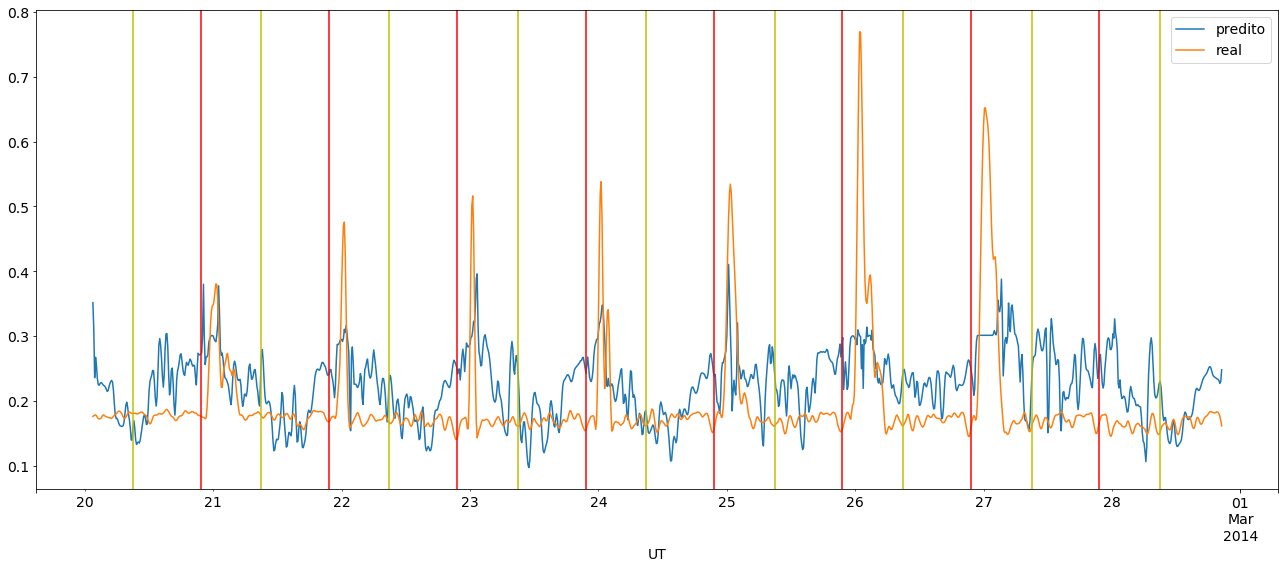

In [7]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal primeira do VTEC

In [8]:
instances_set = ['vtec', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
O erro quadrático médio foi: 0.006747
O erro quadrático total foi: 2.923676
O maior erro por previsão foi: 0.475611
O erro relativo foi: 31.888569%
O número de verdadeiros negativos foi: 523
O número de verdadeiros positivos foi: 143
O número de falsos negativos foi: 10
O número de falsos positivos foi: 591
O POD foi: 0.934641
O FAR foi: 0.805177
A ACC foi: 0.525651
O kappa foi: 0.055905
precission: 0.194823
recal: 0.934641
f1: 0.322435


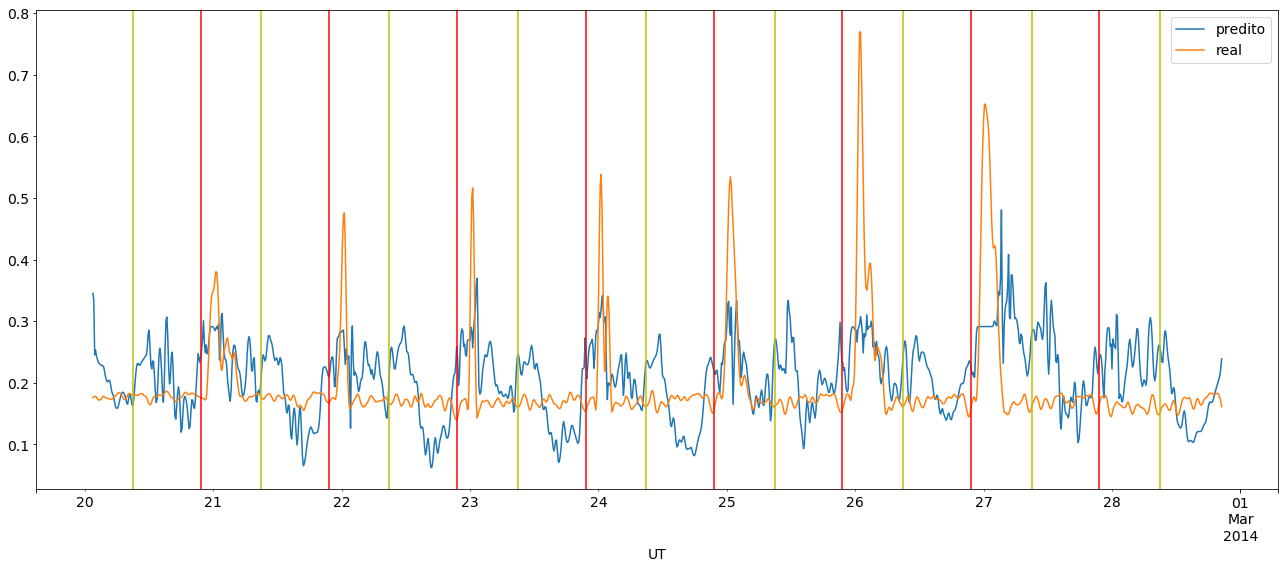

In [9]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal segunda do VTEC

In [10]:
instances_set = ['vtec', 'vtec_dt', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
O erro quadrático médio foi: 0.005934
O erro quadrático total foi: 2.742036
O maior erro por previsão foi: 0.470845
O erro relativo foi: 27.053281%
O número de verdadeiros negativos foi: 584
O número de verdadeiros positivos foi: 147
O número de falsos negativos foi: 6
O número de falsos positivos foi: 530
O POD foi: 0.960784
O FAR foi: 0.782866
A ACC foi: 0.576953
O kappa foi: 0.050716
precission: 0.217134
recal: 0.960784
f1: 0.354217


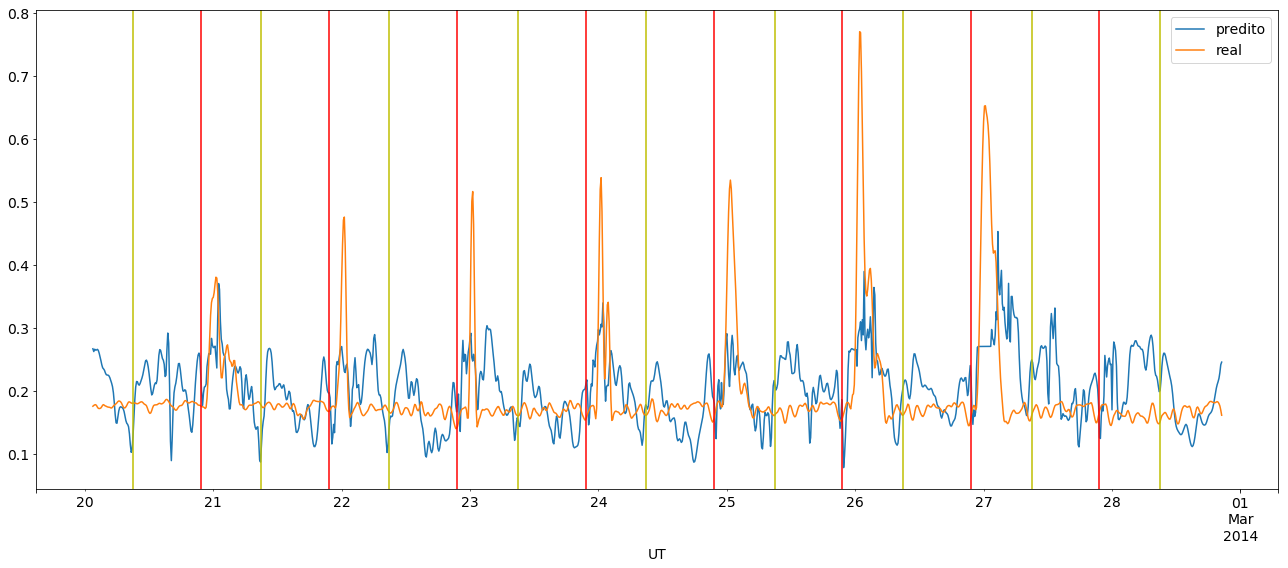

In [11]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem gradiente do VTEC em relação à Pirassununga

In [12]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
O erro quadrático médio foi: 0.006651
O erro quadrático total foi: 2.902853
O maior erro por previsão foi: 0.492323
O erro relativo foi: 30.149208%
O número de verdadeiros negativos foi: 507
O número de verdadeiros positivos foi: 148
O número de falsos negativos foi: 5
O número de falsos positivos foi: 607
O POD foi: 0.967320
O FAR foi: 0.803974
A ACC foi: 0.516969
O kappa foi: 0.057542
precission: 0.196026
recal: 0.967320
f1: 0.325991


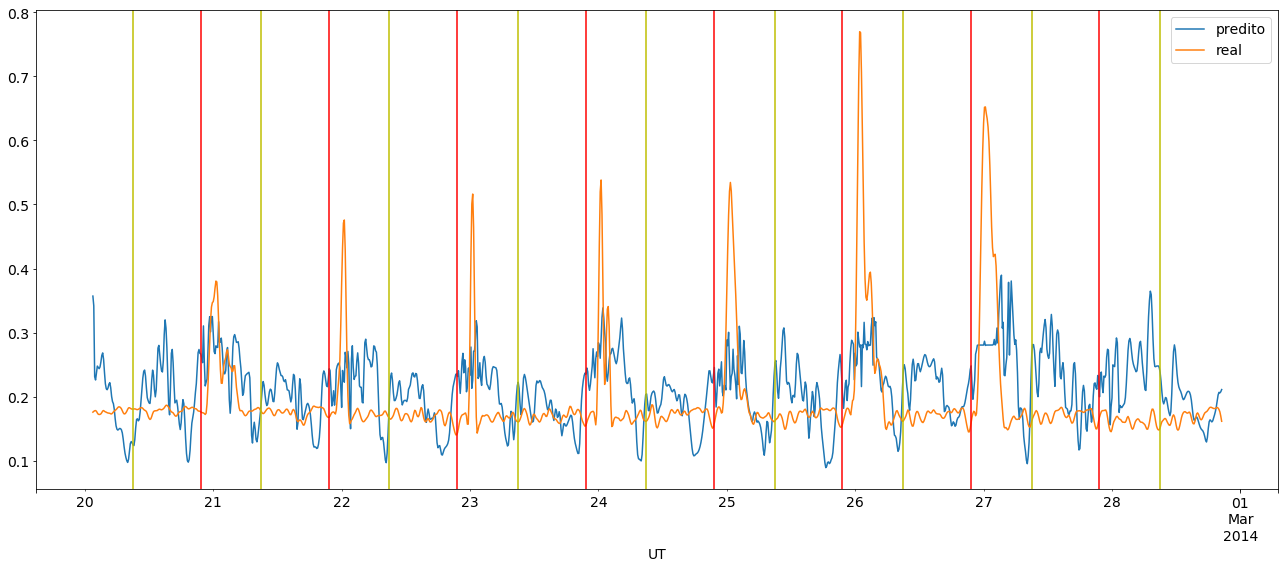

In [13]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal do gradiente do VTEC em relação à Pirassununga

In [14]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
O erro quadrático médio foi: 0.007300
O erro quadrático total foi: 3.041152
O maior erro por previsão foi: 0.502988
O erro relativo foi: 31.613940%
O número de verdadeiros negativos foi: 531
O número de verdadeiros positivos foi: 133
O número de falsos negativos foi: 20
O número de falsos positivos foi: 583
O POD foi: 0.869281
O FAR foi: 0.814246
A ACC foi: 0.524073
O kappa foi: 0.054918
precission: 0.185754
recal: 0.869281
f1: 0.306099


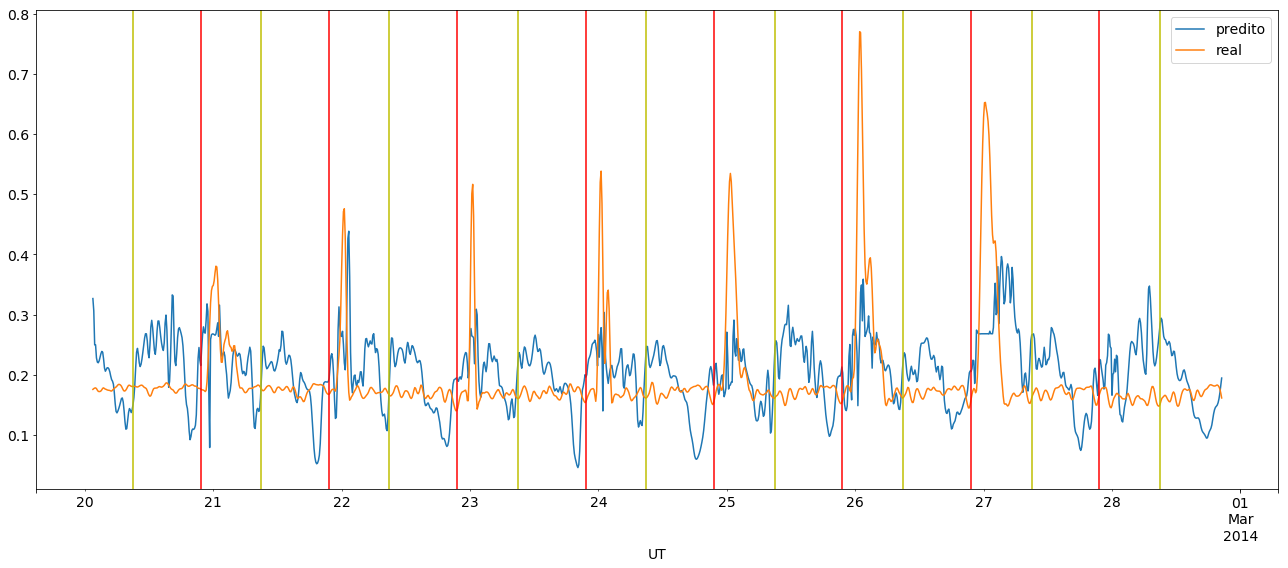

In [15]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem gradiente do VTEC em relação à Brasília

In [16]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2_dt']

Error for the time series sample:
O erro quadrático médio foi: 0.007151
O erro quadrático total foi: 3.009943
O maior erro por previsão foi: 0.495974
O erro relativo foi: 31.732829%
O número de verdadeiros negativos foi: 396
O número de verdadeiros positivos foi: 148
O número de falsos negativos foi: 5
O número de falsos positivos foi: 718
O POD foi: 0.967320
O FAR foi: 0.829099
A ACC foi: 0.429361
O kappa foi: 0.067430
precission: 0.170901
recal: 0.967320
f1: 0.290481


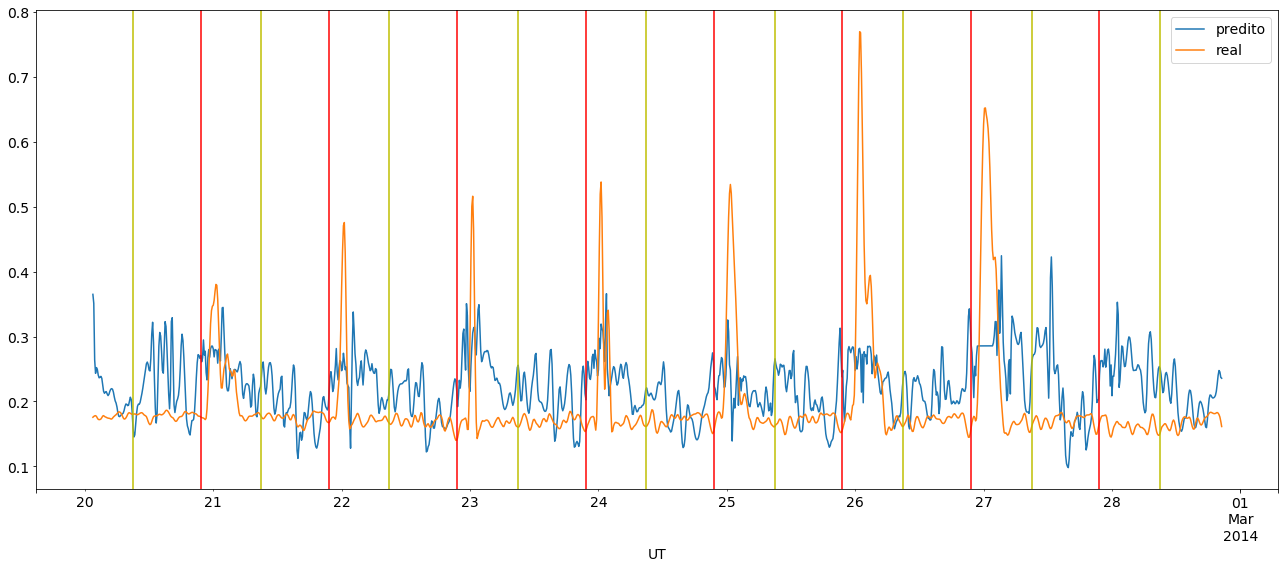

In [17]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal do gradiente do VTEC em relação à Brasília

In [18]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2']

Error for the time series sample:
O erro quadrático médio foi: 0.006868
O erro quadrático total foi: 2.949781
O maior erro por previsão foi: 0.492972
O erro relativo foi: 31.370058%
O número de verdadeiros negativos foi: 479
O número de verdadeiros positivos foi: 150
O número de falsos negativos foi: 3
O número de falsos positivos foi: 635
O POD foi: 0.980392
O FAR foi: 0.808917
A ACC foi: 0.496448
O kappa foi: 0.060230
precission: 0.191083
recal: 0.980392
f1: 0.319829


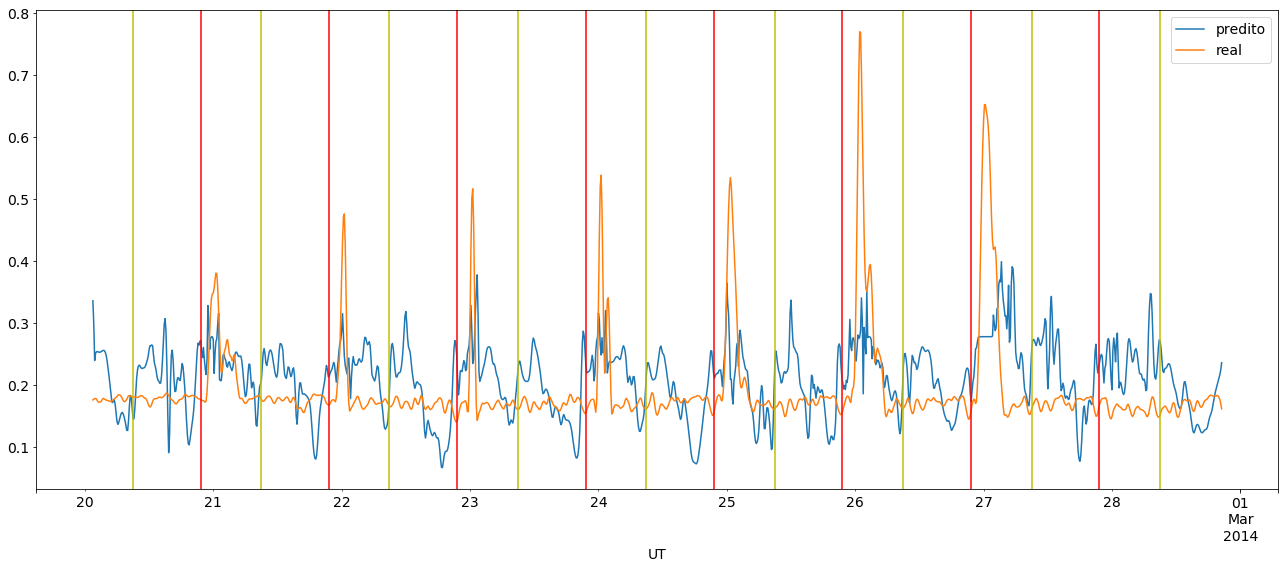

In [19]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')